In [1]:
%load_ext autoreload
%autoreload 2

from config.rnn import default
from models import RNN
from functional import seq
import tensorflow as tf
from tensorpack import (TrainConfig, SyncMultiGPUTrainerParameterServer as Trainer, 
                        PredictConfig, MultiProcessDatasetPredictor as Predictor,
                        SaverRestore, logger)
from tensorpack.callbacks import (ScheduledHyperParamSetter, MaxSaver, ModelSaver,
                                  DataParallelInferenceRunner as InfRunner)
from tensorpack.predict import SimpleDatasetPredictor
from utils import DataManager
from utils.validation import (Accumulator, ApAndAucScore, calcu_ap_auc)

resnet_loc = "./data/resnet_v2_101/resnet_v2_101.ckpt"
logger.set_logger_dir('train_log', action='d')

[1017 19:48:57 @logger.py:74] Argv: /home/fuxiaofeng/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py -f /run/user/1012/jupyter/kernel-791d6cde-8566-4354-ac5e-1e5714722d80.json


In [2]:
config = default
config.stage = [2, 3, 4 ,5, 6]
config.annotation_number = 24
config.weight_decay = 1e-3
config.use_glimpse = True
config.read_time = 5
ignore_restore = ['learning_rate', 'global_step']
save_name = "rnn-23456-dlv-max-auc.tfmodel"

data_manager = DataManager(config)
train_data = data_manager.get_train_stream()
val_data = data_manager.get_validation_stream()
test_data = data_manager.get_test_stream()
model = RNN(config)

Group numbers:
    train: 4129, validation: 1249, test: 1446
Image numbers:
    train: 8258, validation: 2498, test: 2892


In [3]:
tf.reset_default_graph()
train_config = TrainConfig(model=model, dataflow=train_data,
                           callbacks=[
                               ScheduledHyperParamSetter('learning_rate', [(0, 5e-4), (20, 1e-4)]),
                               InfRunner(val_data, [ApAndAucScore()], [0, 1]),
                               ModelSaver(),
                               MaxSaver('val-auc', save_name),
                           ],
                           session_init=SaverRestore(
                               model_path=resnet_loc, ignore=ignore_restore),
                           max_epoch=2, nr_tower=2)
Trainer(train_config).train()

[1017 19:41:02 @input_source.py:235] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...
[1017 19:41:02 @input_source.py:509] Setting up StagingArea for GPU prefetching ...
[1017 19:41:02 @multigpu.py:66] Training a model of 2 towers
[1017 19:41:02 @multigpu.py:87] Building graph for training tower 0...
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.
[1017 19:41:06 @regularize.py:97] Add REGULARIZATION_LOSSES of 7 tensors on the total cost.
[1017 19:41:07 @multigpu.py:87] Building graph for training tower 1...
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.
[1017 19:41:09 @regularize.py:97] Add REGULARIZATION_LOSSES of 7 tensors on the total cost.
[1017 19:41:10 @model_utils.py:47] Model Parameters: 
name                            shape             

[1017 19:41:19 @sessinit.py:119] Restoring checkpoint from ./data/resnet_v2_101/resnet_v2_101.ckpt ...
INFO:tensorflow:Restoring parameters from ./data/resnet_v2_101/resnet_v2_101.ckpt
[1017 19:41:23 @base.py:185] Graph Finalized.
[1017 19:41:24 @param.py:144] After epoch 0, learning_rate will change to 0.00050000
[1017 19:41:26 @concurrency.py:36] Starting EnqueueThread QueueInput/input_queue ...
[1017 19:41:26 @input_source.py:474] Pre-filling staging area ...
[1017 19:42:03 @base.py:231] Start Epoch 1 ...


 16%|#5        |10/63[01:15<06:10, 0.14it/s]

[1017 19:43:26 @base.py:249] Detected Ctrl-C and exiting main loop.


In [ ]:
tf.reset_default_graph()
pred_config = PredictConfig(model=model,
                            session_init=SaverRestore(
                                model_path='train_log/' + save_name),
                            output_names=['logits_export', 'label'])
# pred = Predictor(pred_config, test_data, nr_proc=2, ordered=False)
pred = SimpleDatasetPredictor(pred_config, test_data)
accumulator = seq(pred.get_result()).smap(calcu_ap_auc) \
    .aggregate(Accumulator('ap', 'auc'), lambda accu, dp: accu.feed(dp[1], *dp[0]))
print(accumulator.retrive())

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

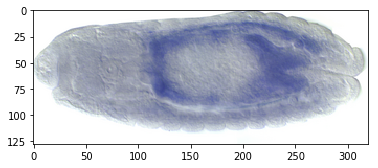

In [13]:
train_data.reset_state()
batch = next(train_data.get_data())
plt.imshow(batch[0][1][0])

In [6]:
tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

[<tf.Tensor 'tower0/custom_cnn/conv1/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/custom_cnn/conv2/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/custom_cnn/conv3/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/rnn/process/fc_read/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/rnn/process/fc_fg/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/rnn/process/fc_ig/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/logits/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>]

In [14]:
from tensorpack.dataflow import TestDataSpeed

In [17]:
%prun TestDataSpeed(train_data, 20).start()

100%|##########|20/20[00:03<00:00, 5.06it/s]